In [1]:
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.57.3
Using datasets version: 4.4.1
Using torch version: 2.9.0+cu126


In [2]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# Inspect the dataset
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [3]:
dataset.column_names

{'train': ['text', 'label']}

In [4]:
dataset.get("train")

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [5]:
dataset.get("train")[0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

In [6]:
import random

random_indexs = random.sample(range(len(dataset["train"])), 5)
random_samples = dataset["train"][random_indexs]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: Margherita pizza topped with fresh basil leaves and juicy tomatoes | Label: food
Text: Jicama in a bowl, sprinkled with chili powder and served with a side of lime wedges for a refreshing snack. | Label: food
Text: Pizza with a white sauce base, topped with spinach and artichokes | Label: food
Text: Telescope positioned on a balcony | Label: not_food
Text: Colorful area rug brightening up a living room | Label: not_food


In [7]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

In [8]:
# Check number of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

In [9]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
188,A basket of fresh strawberries with a sprinkle...,food
5,Coffee table cluttered with magazines,not_food
129,Vintage telephone sitting on a desk,not_food
8,Set of baking sheets stacked in a cabinet,not_food
172,"Spicy prawn curry with fresh mint garnish, fea...",food
107,Sleek silver laptop resting on a wooden desk,not_food
132,"Pizza with a seafood theme, featuring toppings...",food


In [10]:
# Create mapping from id2label and label2id
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


In [11]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey.", "label": "food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey.', 'label': 1}

In [12]:
# Map our dataset labels to numbers
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [13]:
# Shuffle the dataset and view the first 5 samples (will return different results each time)
dataset.shuffle()[:5]

{'text': ['Gluten-free sushi roll using tamari sauce instead of soy sauce.',
  'Pizza with a unique crust, such as cauliflower or zucchini, for a healthier option',
  'Black and white checkered kitchen floor adding a classic touch',
  'Creamy mild korma curry, featuring tender chicken chunks in a rich sauce made with yogurt and cream, sprinkled with sliced almonds.',
  'A girl feeding her rabbit in the garden'],
 'label': [1, 1, 0, 1, 0]}

In [14]:
# Create train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42) # note: seed isn't needed, just here for reproducibility, without it you will get different splits each time you run the cell
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [15]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]

random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: Set of paintbrushes stored in a jar
Label: 0 (not_food)

[INFO] Random sample from testing dataset:
Text: Plate of sushi served with pickled ginger and wasabi.
Label: 1 (food)


In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # uses fast tokenization (backed by tokenziers library and implemented in Rust) by default, if not available will default to Python implementation

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [17]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [18]:
# Try adding a "!" at the end
tokenizer("I love pizza!")

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [19]:
# Get the length of the vocabulary
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


In [20]:
# Does "daniel" occur in the vocab?
tokenizer.vocab["dylan"]

7758

In [21]:
tokenizer("akash")

{'input_ids': [101, 9875, 4095, 102], 'attention_mask': [1, 1, 1, 1]}

In [22]:
tokenizer.convert_ids_to_tokens(tokenizer("akash").input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

In [23]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

In [24]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [25]:
# Map our tokenize_text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to operate across batches of examples rather than only single examples
                                batch_size=1000) # defaults to 1000, can be increased if you have a large dataset

tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [26]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [27]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [28]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


In [29]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2, # can customize this to the number of classes in your dataset
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [31]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

In [32]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

In [33]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch", # was previously "evaluation_strategy"
    save_strategy="epoch",
    save_total_limit=3, # limit the total amount of save checkpoints (so we don't save num_epochs checkpoints)
    use_cpu=False, # set to False by default, will use CUDA GPU or MPS device if available
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # log training results every epoch
    report_to="none", # optional: log experiments to Weights & Biases/other similar experimenting tracking services (we'll turn this off for now)
    # push_to_hub=True # optional: automatically upload the model to the Hub (we'll do this manually later on)
    # hub_token="your_token_here" # optional: add your Hugging Face Hub token to push to the Hub (will default to huggingface-cli login)
    hub_private_repo=False # optional: make the uploaded model private (defaults to False)
)

[INFO] Saving model checkpoints to: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [35]:
from transformers import Trainer

# Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    # Note: the 'tokenizer' parameter will be changed to 'processing_class' in Transformers v5.0.0
    tokenizer=tokenizer, # Pass tokenizer to the Trainer for dynamic padding (padding as the training happens) (see "data_collator" in the Trainer docs)
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1457455194.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.524600,0.174238,1.000000
2,0.118800,0.013929,1.000000
3,0.009600,0.016125,1.000000
4,0.002300,0.001299,1.000000
5,0.001200,0.000825,1.000000
6,0.000900,0.000633,1.000000
7,0.000700,0.000539,1.000000
8,0.000600,0.000492,1.000000
9,0.000600,0.000468,1.000000
10,0.000500,0.000461,1.000000


In [42]:
# Inspect training metrics
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 272.3912
train_samples_per_second: 7.342
train_steps_per_second: 0.257
total_flos: 18110777160000.0
train_loss: 0.06598368306710783
epoch: 10.0


In [40]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [43]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics (we've seen these already)
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.5246,
  'grad_norm': 3.1157748699188232,
  'learning_rate': 9.142857142857143e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.17423835396766663,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.1068,
  'eval_samples_per_second': 468.293,
  'eval_steps_per_second': 18.732,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.1188,
  'grad_norm': 0.3037281334400177,
  'learning_rate': 8.142857142857143e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.013929387554526329,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0754,
  'eval_samples_per_second': 663.16,
  'eval_steps_per_second': 26.526,
  'epoch': 2.0,
  'step': 14}]

In [44]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 3.1157748699188232,
  'learning_rate': 9.142857142857143e-05,
  'loss': 0.5246,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.3037281334400177,
  'learning_rate': 8.142857142857143e-05,
  'loss': 0.1188,
  'step': 14}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.17423835396766663,
  'eval_runtime': 0.1068,
  'eval_samples_per_second': 468.293,
  'eval_steps_per_second': 18.732,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.013929387554526329,
  'eval_runtime': 0.0754,
  'eval_samples_per_second': 663.16,
  'eval_steps_per_second': 26.526,
  'step': 14}]


In [45]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.5246,3.115775,0.000091,1.0,7
1,0.1188,0.303728,0.000081,2.0,14
2,0.0096,0.055729,0.000071,3.0,21
3,0.0023,0.030260,0.000061,4.0,28
4,0.0012,0.017048,0.000051,5.0,35


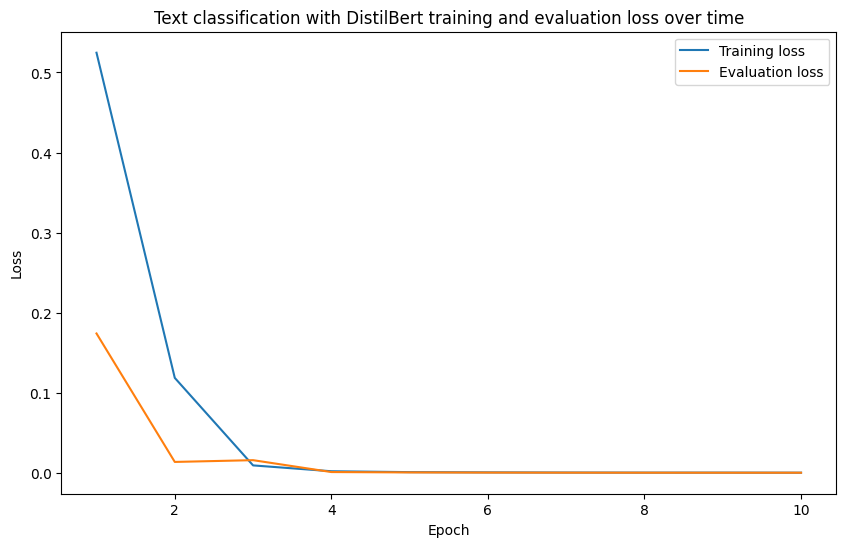

In [46]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()